# Measuring the time to maximum CV
### Params from https://ars.els-cdn.com/content/image/1-s2.0-S2211124716311986-mmc2.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import copy

import lmfit
from lmfit import Model, Parameters

from scipy.special import i0 as I0
from scipy.interpolate import UnivariateSpline

from tqdm import tqdm

from joblib import Parallel, delayed

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Fitting functions

In [3]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location, I0 Bessel order 0
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = np.exp((kappa)*np.cos((x-mu)))#/(2*np.pi*I0(kappa))
    tf = norm_data(tf)
    tf *= fmax
    tf += bsl
    return tf

def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))   

def fit_tc(array, init_kappa):
    x = np.linspace(-np.pi, np.pi, len(array))
    y = array
    
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('mu', 0, False, 0., np.pi),
                  ('kappa', init_kappa, True,  .1, 60.),
                  ('fmax', np.max(array), False, 0.01, np.max(array)),
                 ('bsl', np.min(array), False, 0.0, np.max(array)))

    out = mod.fit(y, pars, x=x, nan_policy='omit')

    return out.best_values

In [4]:
def nakarushton(x, rmax, c50, b, n):
    nkr = b + (rmax-b) * ((x**n) / (x**n + c50**n))
    return nkr

def fit_nkr(array) :
    x = np.linspace(0, 1, len(array))
    y = np.asarray(array)
    
    mod = Model(nakarushton)
    pars = Parameters()
    
    pars.add_many(('rmax',  np.max(y), True,  0.0,  1.), # TODO maybe move back to 200 as max
              ('c50', .5, True,  0.001, 1.),
              ('b', y.min(), True, 0, .8),
              ('n', 2., True,  1., 100.))
    '''pars.add_many(('rmax',  np.max(y), True,  0.0,  2.),
              ('c50', .5, True,  0.001, 10.),
              ('b', y[0], True, y[0] * .1 + .001, y[-1] * 2 ),
              ('n', 5., True,  1., 250.))'''
    
    out = mod.fit(y, pars, x=x, nan_policy='omit', max_nfev = 2000)
    return out.best_values, np.abs(1-out.residual.var() / np.var(y))

## Helper functions

In [5]:
def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
def cirvar(arr) :
    cv_thetas = np.linspace(-np.pi, np.pi, len(arr))
    R = np.sum(arr* np.exp(2j*cv_thetas) / np.sum(arr))
    cv = 1 - np.abs(np.real(R))
    return cv

In [7]:
def kappa_to_hwhh(kappa) :
    # # See equation seven https://academic.oup.com/cercor/article/13/3/225/355481#5079220
    # Only works for kappa > 0.3467
    #hwhh = .5*np.arccos(1+ np.log((1+np.exp(-2*kappa))/2)/kappa)
    #hwhh = hwhh * 180 / np.pi
    #hwhh = np.arccos((np.log(.5) + kappa) / kappa) * 180 / np.pi
    hwhh = .5 * np.arccos( (np.log(.5)+kappa)/kappa) * 180 /np.pi
    return hwhh

def hwhh_to_btheta(hwhh) :
    # Quoth https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L246
    # HWHH = np.sqrt(2*Bt**2*np.log(2))
    # HWHH**2 = 2*Bt**2*np.log(2)
    # (HWHH**2)/2 = Bt**2*np.log(2)
    # (HWHH**2)/(2*np.log(2)) = Bt**2
    # Bt = np.sqrt((HWHH**2)/(2*np.log(2)))
    bt = hwhh**2
    bt = bt /2
    bt = bt/np.log(2)
    bt = np.sqrt(bt)
    return bt # in degrees, if the input is in degree

def kappa_to_btheta(kappa) :
    hwhh = kappa_to_hwhh(kappa)
    btheta = hwhh_to_btheta(hwhh)
    return hwhh

## Simulator functions

In [8]:
def make_kernel(kappae, kappai) :
    # making the probabilistic connection patterns
    exc_prob = tuning_function(orientation_space, 0, kappae, 1, 0)
    exc_prob /= np.sum(exc_prob)
    inh_prob = tuning_function(orientation_space, 0, kappai, 1, 0)
    inh_prob /= np.sum(inh_prob)
    
    return exc_prob, inh_prob

In [9]:
def simulate(thetas, kappa_input, 
             Je, Ji, kappae, kappai, Jlgn, kappa_lgn,
             duration, n, 
             idx_recorded_neuron,
             do_RF = False, return_time = False) :
    '''
    This is a wrapper around the single_simulation function, which allows to run multiple 
    sims with different theta_input, in order to build a single neuron TC
    
    A better way would be to record all output possible for all neurons and average out but 
    that's for later :)
    '''
    
    single_neuron_fr = []
    if return_time : all_outputs = []
    for itheta, theta in enumerate(thetas) :
        output = single_simulation(mu_input = theta, kappa_input = kappa_input,
                                 Je = Je, Ji = Ji, kappae = kappae, kappai = kappai,
                                 Jlgn = Jlgn, kappa_lgn = kappa_lgn,
                                 duration = duration, n = n, do_RF = do_RF)
        single_neuron_fr.append(output['model_outputs'][-1, idx_recorded_neuron])
        if return_time : all_outputs.append(output)
        
    output['single_neuron_fr'] = single_neuron_fr
    if not return_time :
        del output['mu_inputs'] #irrelevant, this is a single run's theta, so can only indice confusion
        del output['model_outputs'] #simpler
        del output['V'] #simpler
        return output
    else :
        del output['model_inputs']
        del output['V'] #simpler
        all_outputs[N_thetas//2]['model_outputs'] = all_outputs[N_thetas//2]['model_outputs'][:, idx_recorded_neuron]
        return all_outputs[N_thetas//2]

In [10]:
def single_simulation(mu_input, kappa_input, 
                     Je, Ji, kappae, kappai, Jlgn, kappa_lgn,
                     duration, n, do_RF = False) :
    
    output = {'mu_input' : mu_input, 'kappa_input' : kappa_input,
              'Je' : Je, 'Ji' : Ji, 'kappae' : kappae, 'kappai' : kappai,
              'Jlgn' : Jlgn, 'kappa_lgn' : kappa_lgn,
              'duration' : duration, 'n' : n, 'do_RF' : do_RF}
    
    # Initializes the array of inputs
    model_inputs = tuning_function(orientation_space,mu_input, 
                                  kappa_input, 1,0)
    
    if do_RF :
        # Multiplies the "LGN" input with a receptive field
        RF = tuning_function(orientation_space, mu_input, kappa_lgn, 1, 0)
        model_inputs *= RF
    
    # Reshaping
    model_inputs = np.repeat(model_inputs, duration, axis = -1)
    model_inputs = model_inputs.reshape((n, duration)).T
    model_inputs[:,300:] = 0 # no input after 300ms
    
    # Kernel of response by probability distributions
    exc_prob, inh_prob = make_kernel(kappae, kappai)
    kernel = exc_prob*Je - inh_prob*Ji
    fourier_j_ctx = np.fft.fft(kernel*.5)

    # Make the movie
    model_outputs = Rrest * np.ones((duration, n))
    
    # Voltage of the model
    V = Rrest / alpha * np.ones((1,n))
    
    # Main iteration
    for it in range(1, duration) :
        Vlgn = Jlgn * model_inputs[it-1,:] # Voltage of input

        fourier_output = np.fft.fft(model_outputs[it-1,:])/n # transforms the output into fourier
        Vctx = n*np.real(np.fft.ifft(fourier_j_ctx*fourier_output)) # and makes it the output
        V = V+(-V + Vlgn + Vctx)*(dt/tau) # keeping track of membrane potentials

        model_outputs[it,:] = np.round(alpha * np.maximum(V, 0)* 10000)/10000 # and rectifcation
        
    output['model_inputs'] = model_inputs[:10,:] # we just keep the beginning
    output['model_outputs'] = model_outputs
    output['V'] = V
    return output

## Data analysis functions

In [11]:
def filter_nkr_array(nkr_array, dico_bounds, r2_min = .9, verbose = True) :
    # Filters a NKR array by a list of dictionnaries, shape of 
    # 'var' : key , 'min' : 0, 'max' : 1
    #ilt_array = copy.copy(nkr_array)
    
    '''for filt in dico_bounds :
        for i, el in enumerate(filt_array) :
            if el['nkr_fit'][0][filt['var']] > filt['min'] :
                if el['nkr_fit'][0][filt['var']] < filt['max'] :
                    if el['nkr_fit'][1] >= r2_min: 
                        print(el['nkr_fit'][0]['b'])
                        pass
                    else :
                        del filt_array[i]
                else :
                    del filt_array[i]
            else :
                del filt_array[i]
        print(i)
    if verbose : print('In size : %s -- Out size : %s' % (len(nkr_array), len(filt_array)))
    return filt_array'''
    lst = copy.copy(nkr_array)
    for bounds in dico_bounds :
        lst= [x for x in lst if bounds['min'] <= x['nkr_fit'][0][bounds['var']] <= bounds['max']]
    lst = [x for x in lst if x['nkr_fit'][1] >= r2_min]
    if verbose : print('In size : %s -- Out size : %s' % (len(nkr_array), len(lst)))
    return lst

## Plotting functions

In [12]:
def plot_kernel(Je, Ji, kappae, kappai) :
    fig, axs = plt.subplots(figsize = (10,5), ncols = 2)

    exc_prob, inh_prob = make_kernel(Je, Ji, kappae, kappai)
    axs[0].plot(orientation_space, exc_prob)
    axs[0].plot(orientation_space, inh_prob)
    axs[0].set_title('Proba distribution')

    axs[1].plot(exc_prob*Je - inh_prob*Ji)
    axs[1].set_title('Cortical kernel')
    plt.show()

In [13]:
def plot_I_O_tcs(outputs) :
    # plots the TCs of the input and the TCs of the output
    # Has to be organized in the length of kappa_inputs
    fig, axs = plt.subplots(figsize = (12,5), ncols = 2)
    cols = plt.cm.viridis(np.linspace(0, 1., len(kappa_inputs)))
    
    hwhh_inputs = kappa_to_hwhh(kappa_inputs)
    for i0, _ in enumerate(outputs) :
        # Hack of the year
        if i0 == 0 or i0 == len(kappa_inputs)-1 or i0 == len(kappa_inputs)//2 :
            label = '%.2f' %hwhh_inputs[i0]
        else :
            label = '_nolabel_' #turns out everything with an underscore is skipped
            
        axs[0].plot(orientation_space, outputs[i0]['model_inputs'][1,:], color = cols[i0], 
                   label = label)
        axs[1].plot(thetas, outputs[i0]['single_neuron_fr'], color = cols[i0])
        
    axs[0].legend(title = 'HWHH')
    axs[0].set_title('Input TC to the model')
    axs[1].set_title('Output TC of the model')
    
    return fig, axs

In [14]:
def plot_I_O_neurometric(outputs, ax, color, label = '_nolabel_',
                        metric = 'hwhh') :
    y = []
    for sim in outputs :
        if metric == 'hwhh' :
            kappa = fit_tc(sim['single_neuron_fr'], init_kappa = sim['kappa_input'])['kappa']
            y.append(kappa_to_hwhh(kappa))
        elif metric == 'cv' :
            y.append(cirvar(sim['single_neuron_fr']))
        
    ax.plot(kappa_to_hwhh(kappa_inputs), y, color = color, label = label)
    
    return ax

# Default parameters and a single run

In [15]:
n = 128# number of neurons
duration = 350 # ms
orientation_space = np.linspace(-np.pi, np.pi, n)

alpha = 10.6 #gain of voltage to FR
Rrest = 0 # resting firing rate
tau = 10.8 # membrane time constant (ms)
dt = .1 # simulation step time

Jlgn = 9.57
Je, Ji = 1.71, 2.0178 # see notebook on notability for the maths
#Je, Ji = 0,0
kappae, kappai  = 1.59, 1.16
kappa_lgn = 1.56

In [16]:
metric = 'cv' # cv or hwhh, depending on what we're measuring for the output TC

In [17]:
N_thetas = 8 # number of oriented stims, to build a single neuron tuning curve
offset = np.pi/8 # avoid border effects
thetas = np.linspace(-np.pi+offset, np.pi-offset, N_thetas)

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Taking multiple Ke/Ki ratio, and seeing what is the time constant at the end

In [19]:
n_scans = 200 # set this to be the same as in recurrent.ipynb, otherwise you can't relate NKR to delays
scan_kappaes = np.linspace(.35, 7., n_scans)
scan_kappais = np.linspace(.35, 7., n_scans)
kappa_inputs = np.linspace(22.85, .7625, 2) # we only need two here, because we're only looking at timing and not NKR

#shape is inputs, kappaes, kappais
iter_prod = list(itertools.product(range(len(kappa_inputs)),
                                   range(n_scans),
                                   range(n_scans)))

In [20]:
do_load = False
do_save = True

In [21]:
if not do_load and do_save :
    output_sims = Parallel(n_jobs = -1, backend = 'multiprocessing')(delayed(simulate)(
                        thetas = thetas, kappa_input = kappa_inputs[it[0]],
                        Je = Je, Ji = Ji,
                        kappae = scan_kappaes[it[1]], kappai = scan_kappais[it[2]],
                        Jlgn = Jlgn, kappa_lgn = None, duration = duration, n = n,
                        idx_recorded_neuron = n//2,
                        do_RF = False, return_time = True)
                for it in tqdm(iter_prod, desc = 'Simulating', total = len(iter_prod)))
    
    mid_vals_bt0, mid_vals_bt36 = [], []
    for this_scan_kappae in tqdm(scan_kappaes, 'Re-ordering the simulations') :
        for this_scan_kappai in scan_kappais :
            # Filtering the outputs
            outputs = [x for x in output_sims if x['kappae'] == this_scan_kappae and
                                                    x['kappai'] == this_scan_kappai]
            sorted_out = sorted(outputs, key = lambda d : d['kappa_input'], reverse = False)
            
            fr_array = np.zeros((kappa_inputs.shape[0],duration ))
            for ikappa, kappa in enumerate(kappa_inputs) :
                fr_array[ikappa] = sorted_out[ikappa]['model_outputs']

            fr = fr_array[0,:]
            sought_val = np.min(fr)+(np.max(fr)-np.min(fr))/2
            mid_vals_bt0.append(find_nearest(fr, sought_val))

            fr = fr_array[-1,:]
            sought_val = np.min(fr)+(np.max(fr)-np.min(fr))/2
            mid_vals_bt36.append(find_nearest(fr, sought_val))
        
    np.save('./data/time_scans_bt0.npy', mid_vals_bt0)
    np.save('./data/time_scans_bt36.npy', mid_vals_bt36)

elif not do_save and do_load :
    mid_vals_bt0 = np.load('./data/time_scans_bt0.npy', allow_pickle = True)
    mid_vals_bt36 = np.load('./data/time_scans_bt36.npy', allow_pickle = True)

Re-ordering the simulations: 100%|██████████| 200/200 [09:41<00:00,  2.91s/it]


In [22]:
iter_prod = list(itertools.product(scan_kappaes, scan_kappais))

/tmp/ipykernel_21489/2923707804.py:20: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(img_params, levels = np.linspace(vmin, vmax, nlevels, endpoint = True),
/tmp/ipykernel_21489/2923707804.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


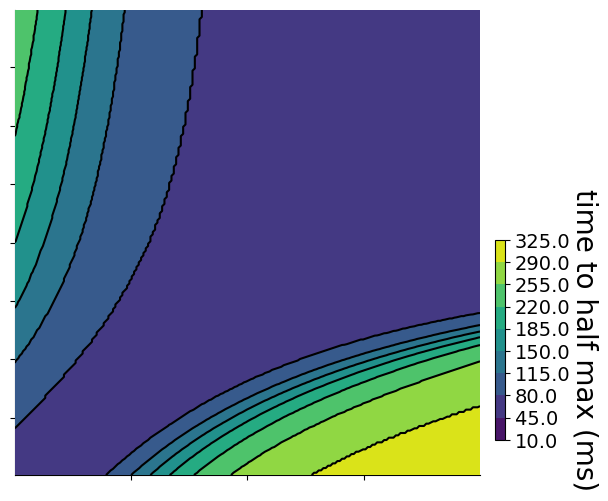

In [23]:
# correlating kappae/kappai
fig, ax = plt.subplots(figsize = (5,5))
nlevels = 10
vmin = 10
vmax = 325

kappaes_graph = [x[0] for x in iter_prod]
kappais_graph = [x[1] for x in iter_prod]
time_val = [x for x in mid_vals_bt0]

img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
count_array = np.zeros_like(img_params)
for i, _ in enumerate(time_val) :
    idx_kappai = np.where(scan_kappais == kappais_graph[i])[0]
    idx_kappae = np.where(scan_kappaes == kappaes_graph[i])[0]
    img_params[idx_kappai, idx_kappae] += time_val[i]
    count_array[idx_kappai, idx_kappae] +=1
img_params /= count_array # cheaptrick to make the array a mean

cs = ax.contourf(img_params, levels = np.linspace(vmin, vmax, nlevels, endpoint = True), 
                cmap = plt.cm.viridis,
               vmin = vmin, vmax = vmax, 
               origin = 'lower', zorder = 30, linewidths = 0.5)
cs2 = ax.contour(img_params, cs.levels, colors='k', zorder = 50, origin = 'lower')

cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                        ax.get_position().y0+0., #bottom of the colorbar
                        0.02, #width of the colorbar
                        .4]) #height of the colorbar
cb = fig.colorbar(cs, cax = cax, ticks = np.linspace(vmin, vmax, nlevels))
cb.ax.set_yticklabels(np.round(np.linspace(vmin, vmax, nlevels), 1))

ax.set_xticklabels([])
ax.set_yticklabels([])
cax.set_ylabel('time to half max (ms)', rotation = 270, labelpad = 20,
              fontsize = 20)
cb.ax.tick_params(labelsize = 14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/imgtime_bt0.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

/tmp/ipykernel_21489/2278783306.py:21: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(img_params, levels = np.linspace(vmin, vmax, nlevels, endpoint = True),
/tmp/ipykernel_21489/2278783306.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


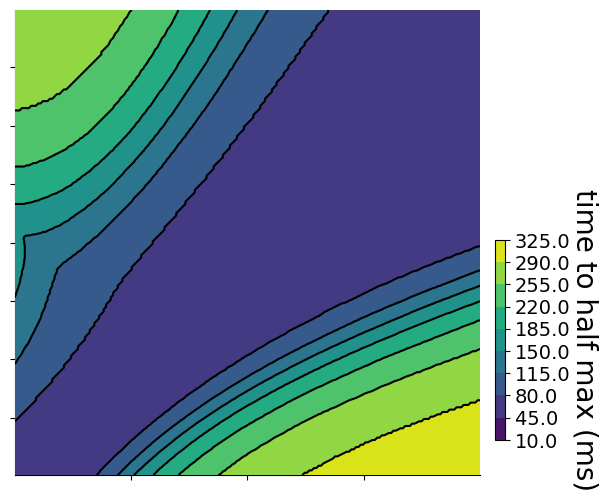

In [24]:
# correlating kappae/kappai
fig, ax = plt.subplots(figsize = (5,5))
nlevels = 10
vmin = 10
vmax = 325


kappaes_graph = [x[0] for x in iter_prod]
kappais_graph = [x[1] for x in iter_prod]
time_val = [x for x in mid_vals_bt36]

img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
count_array = np.zeros_like(img_params)
for i, _ in enumerate(time_val) :
    idx_kappai = np.where(scan_kappais == kappais_graph[i])[0]
    idx_kappae = np.where(scan_kappaes == kappaes_graph[i])[0]
    img_params[idx_kappai, idx_kappae] += time_val[i]
    count_array[idx_kappai, idx_kappae] +=1
img_params /= count_array # cheaptrick to make the array a mean

cs = ax.contourf(img_params, levels = np.linspace(vmin, vmax, nlevels, endpoint = True), 
                cmap = plt.cm.viridis,
               vmin = vmin, vmax = vmax, 
               origin = 'lower', zorder = 30, linewidths = 0.5)
cs2 = ax.contour(img_params, cs.levels, colors='k', zorder = 50, origin = 'lower')


cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                        ax.get_position().y0+0., #bottom of the colorbar
                        0.02, #width of the colorbar
                        .4]) #height of the colorbar
cb = fig.colorbar(cs, cax = cax, ticks = np.linspace(vmin, vmax, nlevels))
cb.ax.set_yticklabels(np.round(np.linspace(vmin, vmax, nlevels), 1))

cax.set_ylabel('time to half max (ms)', rotation = 270, labelpad = 20,
              fontsize = 20)
cb.ax.tick_params(labelsize = 14)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/imgtime_bt36.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

/tmp/ipykernel_21489/3245270132.py:35: UserWarning: linewidths is ignored by contourf
  cs = ax.contourf(test_img, levels = np.linspace(vmin, vmax, nlevels, endpoint = True),
/tmp/ipykernel_21489/3245270132.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


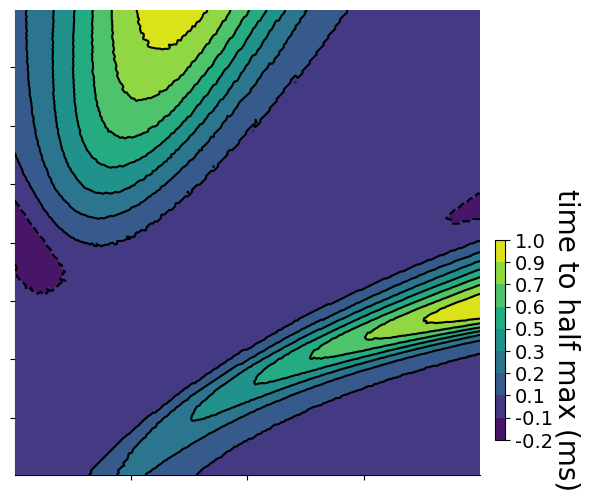

In [30]:
# correlating kappae/kappai
fig, ax = plt.subplots(figsize = (5,5))
nlevels = 10
vmin = -0.2
vmax = 1

kappaes_graph = [x[0] for x in iter_prod]
kappais_graph = [x[1] for x in iter_prod]
time_val = [x for x in mid_vals_bt36]
img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
count_array = np.zeros_like(img_params)
for i, _ in enumerate(time_val) :
    idx_kappai = np.where(scan_kappais == kappais_graph[i])[0]
    idx_kappae = np.where(scan_kappaes == kappaes_graph[i])[0]
    img_params[idx_kappai, idx_kappae] += time_val[i]
    count_array[idx_kappai, idx_kappae] +=1
img_params /= count_array # cheaptrick to make the array a mean
time_val_bt36 = np.copy(img_params)

kappaes_graph = [x[0] for x in iter_prod]
kappais_graph = [x[1] for x in iter_prod]
time_val = [x for x in mid_vals_bt0]
img_params = np.zeros((len(scan_kappais), len(scan_kappaes)))
count_array = np.zeros_like(img_params)
for i, _ in enumerate(time_val) :
    idx_kappai = np.where(scan_kappais == kappais_graph[i])[0]
    idx_kappae = np.where(scan_kappaes == kappaes_graph[i])[0]
    img_params[idx_kappai, idx_kappae] += time_val[i]
    count_array[idx_kappai, idx_kappae] +=1
img_params /= count_array # cheaptrick to make the array a mean
time_val_bt0 = np.copy(img_params)

test_img = np.log(time_val_bt36 / time_val_bt0)

cs = ax.contourf(test_img, levels = np.linspace(vmin, vmax, nlevels, endpoint = True), 
                cmap = plt.cm.viridis,
               vmin = vmin, vmax = vmax, 
               origin = 'lower', zorder = 30, linewidths = 0.5)
cs2 = ax.contour(test_img, cs.levels, colors='k', zorder = 50, origin = 'lower')

cax = fig.add_axes([ax.get_position().x1+0.1, # offset from the right of the axis
                        ax.get_position().y0+0., #bottom of the colorbar
                        0.02, #width of the colorbar
                        .4]) #height of the colorbar
cb = fig.colorbar(cs, cax = cax, ticks = np.linspace(vmin, vmax, nlevels))
cb.ax.set_yticklabels(np.round(np.linspace(vmin, vmax, nlevels), 1))

cax.set_ylabel('time to half max (ms)', rotation = 270, labelpad = 20,
              fontsize = 20)
cb.ax.tick_params(labelsize = 14)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
fig.tight_layout()
fig.savefig('./figs/img_time_ratio.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight', transparent = True)
plt.show()

# Reloading the recurrent.ipynb data to link the temporality to the NKR

In [26]:
reload_ultratuned = np.load('./data/single_ultratuned.npy', allow_pickle = True)
reload_untuned = np.load('./data/single_untuned.npy', allow_pickle = True)
reload_tuned = np.load('./data/single_tuned.npy', allow_pickle = True)

In [27]:
kappaes_reload, kappais_reload = [], []
for el in reload_tuned:
    kappaes_reload.append(el['kappae'])
    kappais_reload.append(el['kappai'])
kappaes_reload = np.asarray(kappaes_reload)
kappais_reload = np.asarray(kappais_reload)

all_times_bt0, all_times_bt36 = [], []
for i, _ in enumerate(kappais_reload) :
    idx_i = np.where(scan_kappais == kappais_reload[i])[0]
    idx_e = np.where(scan_kappaes == kappaes_reload[i])[0]
    all_times_bt0.append(time_val_bt0[idx_i, idx_e])
    all_times_bt36.append(time_val_bt36[idx_i, idx_e])
    
print('tuned')
print(np.percentile(all_times_bt0, 5), np.percentile(all_times_bt0, 95))
print(np.percentile(all_times_bt36, 5), np.percentile(all_times_bt36, 95))


kappaes_reload, kappais_reload = [], []
for el in reload_untuned:
    kappaes_reload.append(el['kappae'])
    kappais_reload.append(el['kappai'])
kappaes_reload = np.asarray(kappaes_reload)
kappais_reload = np.asarray(kappais_reload)

all_times = []
for i, _ in enumerate(kappais_reload) :
    idx_i = np.where(scan_kappais == kappais_reload[i])[0]
    idx_e = np.where(scan_kappaes == kappaes_reload[i])[0]
    all_times_bt0.append(time_val_bt0[idx_i, idx_e])
    all_times_bt36.append(time_val_bt36[idx_i, idx_e])
    
print('untuned')
print(np.percentile(all_times_bt0, 5), np.percentile(all_times_bt0, 95))
print(np.percentile(all_times_bt36, 5), np.percentile(all_times_bt36, 95))


kappaes_reload, kappais_reload = [], []
for el in reload_ultratuned:
    kappaes_reload.append(el['kappae'])
    kappais_reload.append(el['kappai'])
kappaes_reload = np.asarray(kappaes_reload)
kappais_reload = np.asarray(kappais_reload)

all_times = []
for i, _ in enumerate(kappais_reload) :
    idx_i = np.where(scan_kappais == kappais_reload[i])[0]
    idx_e = np.where(scan_kappaes == kappaes_reload[i])[0]
    all_times_bt0.append(time_val_bt0[idx_i, idx_e])
    all_times_bt36.append(time_val_bt36[idx_i, idx_e])
    
print('ultratuned')
print(np.percentile(all_times_bt0, 5), np.percentile(all_times_bt0, 95))
print(np.percentile(all_times_bt36, 5), np.percentile(all_times_bt36, 95))

tuned
261.0 274.0
268.75 279.0
untuned
89.3 274.0
93.3 279.0
ultratuned
74.4 274.0
94.0 279.0
